In [64]:
from math import sqrt
from random import uniform
from time import time,sleep
from multiprocessing import Pool
import ipyparallel as ipp
import numpy as np

def MCpi(number_of_darts):
    number_of_darts_in_circle = 0.0
    
    for n in range(number_of_darts):
        x,y = uniform(0,1),uniform(0,1)
        if sqrt((x-0.5)**2+(y-0.5)**2)<=0.5:
            number_of_darts_in_circle += 1.0
    
    return number_of_darts_in_circle

def throwdart(x):
    from random import uniform
    from math import sqrt
    
    x,y = uniform(0,1),uniform(0,1)
    if sqrt((x-0.5)**2+(y-0.5)**2)<=0.5:
        dart_in_circle = True
    else:
        dart_in_circle = False
    
    return dart_in_circle


In [65]:
darts_range = np.array([10,100,1000,10000,100000,1000000,10000000])

serial_times = np.zeros(len(darts_range))
serial_rates = np.zeros(len(darts_range))

mp_times = np.zeros(len(darts_range))
mp_rates = np.zeros(len(darts_range))

ipp_times = np.zeros(len(darts_range))
ipp_rates = np.zeros(len(darts_range))

In [66]:
# simple serial 

for iTrial in range(len(darts_range)):
    
    number_of_darts = darts_range[iTrial]
    
    start_time = time()
    number_of_darts_in_circle = MCpi(number_of_darts)
    end_time = time()

    serial_times[iTrial] = end_time - start_time
    serial_rates[iTrial] = number_of_darts/serial_times[iTrial]


In [67]:
# multiprocessing

num_processes = 16
pool = Pool(processes=num_processes)

for iTrial in range(len(darts_range)):
    
    number_of_darts = darts_range[iTrial]
    darts_per_process = [int(number_of_darts/num_processes) for x in range(num_processes)]

    ii=0
    while sum(darts_per_process)<number_of_darts:
        if ii>=num_processes:
            ii=0
        darts_per_process[ii]+=1
        ii+=1

    start_time = time()
    ndarts_per_pool = pool.map(MCpi,darts_per_process)
    number_of_darts_in_circle = sum(ndarts_per_pool)
    end_time = time()

    mp_times[iTrial] = end_time - start_time
    mp_rates[iTrial] = number_of_darts/mp_times[iTrial]


del pool



In [68]:
# ipyparallel

rc = ipp.Client()
v = rc[:]

for iTrial in range(len(darts_range)):
    
    number_of_darts = darts_range[iTrial]

    start_time = time()
    out = v.map_sync(throwdart,range(number_of_darts))
    number_of_darts_in_circle = sum(out)
    end_time = time()

    ipp_times[iTrial] = end_time - start_time
    ipp_rates[iTrial] = number_of_darts/ipp_times[iTrial]
    

/home/sam/anaconda3/lib/python3.6/site-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@sam-ubuntu')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


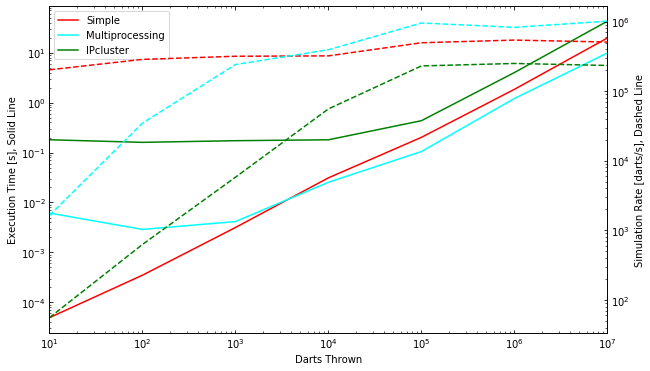

In [72]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.loglog(darts_range,serial_times,label="Simple",color="red")
ax1.loglog(darts_range,mp_times,label="Multiprocessing",color="cyan")
ax1.loglog(darts_range,ipp_times,label="IPcluster",color="green")
ax1.tick_params(which="both",top="on",direction="in")
ax1.legend()
ax1.set_xlabel("Darts Thrown");
ax1.set_ylabel("Execution Time [s], Solid Line");
ax1.set_xlim([darts_range[0],darts_range[-1]])


ax2 = ax1.twinx()
ax2.loglog(darts_range,serial_rates,label="Simple",color="red",linestyle="dashed")
ax2.loglog(darts_range,mp_rates,label="Multiprocessing",color="cyan",linestyle="dashed")
ax2.loglog(darts_range,ipp_rates,label="IPcluster",color="green",linestyle="dashed")
ax2.set_ylabel("Simulation Rate [darts/s], Dashed Line");
ax2.tick_params(which="both",direction="in")

